# Reinforcement Learning: DQN algorithm using OpenAI Gym and PyTorch


 What do reinforcement learning algorithms learn? 
 
 Policies and value functions
 
 Optimality -- Bellman optimality equation
 
 Q-learning objective

Q-learning is the first technique we'll discuss that can solve for the optimal policy in an MDP.

The objective of Q-learning is to find a policy that is optimal in the sense that the expected value of the total reward over all successive steps is the maximum achievable. So, in other words, the goal of Q-learning is to find the optimal policy by learning the optimal Q-values for each state-action pair. 

Q-learning with value iteration --  Value iteration

The Q-learning algorithm iteratively updates the Q-values for each state-action pair using the Bellman equation until the Q-function converges to the optimal Q-function,


 Exploration vs. exploitation 
Epsilon greedy strategy 

Updating the Q-value 

 The learning rate 
 
  Calculating the new Q-value 
  
### Deep Q-Learning - Combining Neural Networks and Reinforcement Learning
https://deeplizard.com/learn/video/wrBUkpiRvCA

Experience Replay and Replay Memory 




### CartPole-v0

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

**CartPole-v0 defines "solving" as getting average reward of 195.0 over 100 consecutive trials.**

https://gym.openai.com/envs/CartPole-v0/

### Understanding the Markov Model

We speak to the world as a diagram of states associated with transitions or actions. It implies that to anticipate your future state, you will just need to consider your present state and the activity that you perform. The key here is that you don’t have to think about your past states. This is the thing that individuals call a Markov Model. In spite of the fact that your past has effects on your future, this model works since you can generally encode data about the past in your present state.



1. We will use __DQN to control a cartpole model__. Here, the cart-pole model without optimization behaves as follows:

In [1]:
import gym
#import Box2D
env = gym.make('CartPole-v0')
env.reset()
for _ in range(500):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

/home/shivam/anaconda3/envs/dl/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


2. Now we will __import all required libraries__ to get started with DQN for cart-pole model.

Some Important things to notice here are:

We will use PyTorch neural network API for our networks. And this notebook is loosely based on DQN tutorial on __[https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html]__ (PyTorch’s website)

And we are using gym library from open.ai.


In [2]:
%matplotlib inline
import numpy as np
import gym
import random
import time
import math
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

3. Here we take measures to setup display

In [3]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display 

### Neural-Network using PyTorch
4. the __nn package__ imported earlier consists all the essential things to make a neural network. We have a class called *__Module__* in nn which is the base class for all NN modules, hence our network and all of its layers will extend this class. There are few things to note here:
    * Our DQN will receive screenshot like images of cart-pole as inputs, so we decide the Height and Width of these image imputs in the *__init__()*
    * We'll have 2 fully connnected layers *__fc__*(linear layers) and one output layer.
    * $1^{st}$ layer will take in image(height x width x 3) inputs, 3 for RBG color channels and 24 outputs.
    * $2^{nd}$ layer = 24 inputs, 32 outputs.
    * Output layer = 32 inputs, 2 outputs. 2 outputs = {move_left, move_right} to the cartpole.  
    
Moreover, we have forward() for forward pass to the network. It first flattens the image tensor(t) and then performs ReLU on them.

In [5]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)
        self.fc2 = nn.Linear(in_features=24, out_features=24)
        self.fc3 = nn.Linear(in_features=32, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)
       
        
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        
        return t

5. Here, we create experiences from the replay memory in order to train our network. We implement __Experience__ class from where we can create instances of experience objects that can be stored in and sampled from replay memory.
    * Here, namedtuple() creates tuples with named fields, and it return a tuple subclass called 'Experience'. This 'Experience' will then be used to create tuple-like objects with fields: state, action, next_state, reward.

In [6]:
Exp = namedtuple(
    'Experience',
    ('state','action','next_state','reward')
)

In [7]:
# Example of experience tuple
e = Exp(1,2,3,2)
e

Experience(state=1, action=2, next_state=3, reward=2)

### Replay Memory
6. Now we create __Replay Memory class__ which will store the Experiences we just created. This is done using a 'Capacity' which we will decide.

In [8]:
class ReplayMemory():
    def __init__(self, Capacity):
        self.Capacity = Capacity
        self.memory = [] # This will contain the stored experiences
        self.push_count = 0 # To know how many experiences we have added to the memory
    
    def push(self, experience): # to insert experience in memory
        if len(self.memory) < self.Capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count%self.Capacity] = experience # overriding oldest memory first.
            
    def sample(self, batch_size): # to return a sample from memory ( with size = batch_size) to Train DQN. 
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size): # check 
        return len(self.memory) >= batch_size           

### Epsilon-Greedy Strategy
7. Now we create a class for __Epsilon-Greedy Strategy__ as follows:

In [9]:
class EGreedy():
    def __init__(self, start, end, decay):
        self.start = start
        self.decay = decay
        self.end = end
        
    def get_exp_rate(self,current_step):
        return self.end + (self.start -self.end) * math.exp(-1.*current_step*self.decay)

### Agent Defination
8. Now we create a class for __Agent()__. This class will require a strategy and set of available actions. *strategy* will come from Epsiolon-Greedy Class and in cart-pole model there are only 2 options: move left or right.
   Agent will also have *device* variable, this will tell PyTorch what device to use for tensor calculations (CPU or GPU).

In [10]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    
    def selet_action(self, state, policy_net): # ploicy_net is our DQN being trained to learn optimal policy
        rate = strategy.get_exp_rate(self.current_step) # gettin rate from e-greedy Class
        self.current_step += 1
        
        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploit
                #returns action that corresponds to highest Q-value output from poilcy network for given state
                

## Environment:
9. Now we create an __Environment__ class to manage our cart-pole environment. It will wrap gym's environment capabilities like reset(), close(), render(), done; along with some added functionalities like image pre-processing. This also uses *device* for tensor calculations.

### Image Pre-processing:
__Note:__ The states in the environment will be represented as screenhots-like images. In fact, __a state__ in the environment will be represented as the __difference between current screen and previous screeen.__
(*This will allow the agent to take velocity of the pole into account from one single image*)
Some note-worthy functions which are used :

1. *__get_processed_screen()__*: 
    1. First render the environment as RGB array. Then transposes this array into order of channels by height by width, this is what our PyTorch DQN expects. 
    * Then crops the image using _cropped()_ function. 
    * Then the cropped image is further processed for re-scaling and final data conversion, using _transform_screen_data()_ function.
2. *__transform_screen_data()__*:
    1. First converts the input image to a numpy array with same size and shape as of the screen, using ascontinousarray() function of numpy library.
    2. Then, we rescale the values by dividing all of them by 255. This is required for neural network input and is a typical process that occurs during image processing.
    3. Then, this array is converted to a tensor in order to perform image transformations.
    4. These, image transformations include: resizing, conversion to PIL image and final conversion to a tensor form.
3. *__cropped()__*: crops the input image and returns image with height cropped 20% from the top and 40% from the bottom.

In [11]:
class CartPole():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped 
        # unwrapped gives us access to behind-the-scenes dynamics of the environment. 
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    def reset(self):
        self.env.reset()
        self.current_screen = None
    
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def perform_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
            return self.current_screen is None
    
    #to return current state of env in form of processed image of the screen
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        #THIS DIFFERERNCE REPRESENTS A SINGLE STATE
    
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects [C x H x W]
        screen = self.cropped(screen)
        return self.transform_screen_data(screen)
    
    def cropped(self, screen):
        screen_height = screen.shape[1]
        screen_width = screen.shape[2]
        
        # Strip off top and bottom
        top = int(screen_height * 0.4) # 40% of the screen height to remove top 40% off the screen
        bottom = int(screen_height * 0.8) # 80% of the screen height to remove bottom 20% off the screen
        
        # strip off left and right
        #left = int(screen_width * 0.4)
        #right = int(screen_width * 0.6)
        #screen = screen[:, top:bottom,left:right]
        screen = screen[:, top:bottom,:] # Sliced Screen
        return screen
    
    def transform_screen_data(self, screen):
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchVision Package to compose image transforms
        resize = T.Compose([ 
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device)#add batch dimension: Imgs passed to DQN in batches
    
        

### Example of screens:
10. following are examples of processed and non-processed screen:
### example of non-processed screen:

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
sys = CartPole(device)
sys.reset()

In [16]:
#plt.figure()
#screen = sys.render('rgb_array')

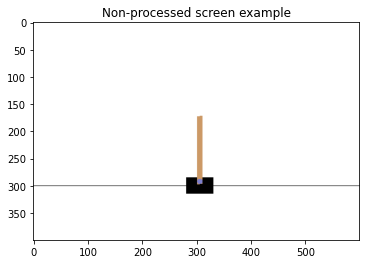

In [17]:
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

### Example of a processed screen

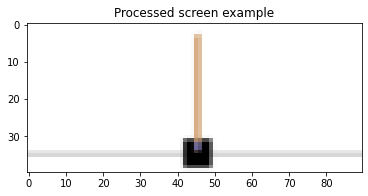

In [18]:
screen = sys.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

### Example of starting state


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

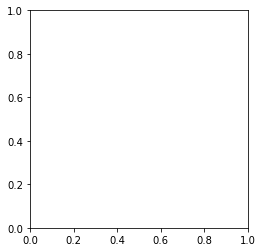

In [19]:
screen = sys.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation = 'none')
plt.title('processed initial screen')
plt.show()

### Example of non-starting processed screen
__Note:__ As we are taking difference between two subsequent screens, most pixel values will be zero. Only things visible are due to movement of cart-pole from previous screent to new screen.

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

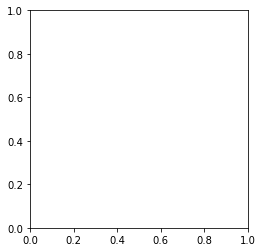

In [20]:
for i in range(5):
    sys.perform_action(torch.tensor([1]))
        
screen = sys.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation = 'none')
plt.title('processed initial screen')
plt.show()

### Visualize the results:
11. Some function to visualize the learning:

The __plot()__ uses matplotlib library. This function will plot the duration of each episode, as well as the 100 episode moving average. condition for solving this problem is that the average reward must be >= 195 over 100 consecutive episodes.

The __moving_average()__ function plots a moving average by using *unfold()* to first slice of size = period input and then taking mean of the tensors in that period. Moreover, it plots values for each step.

In [21]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    plt.plot(moving_average(moving_avg_period, values))
    plt.pause(0.001)
    if is_ipython: display.clear_output(wait=True)
        
def moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

Following shows usage of the *moving_average()* function with an example episode of length 250 and moving average of 50

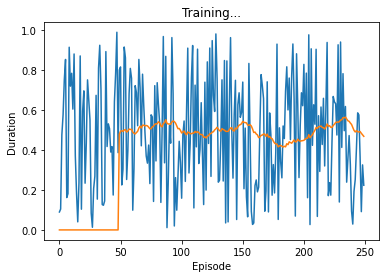

In [22]:
# example of moving average
plot(np.random.rand(250), 50)

### Training Setup:
12. Now we do the needful for initiating the algorithm.

12(a) First, we set the hyperparameters:

In [23]:
batch_size = 512     # minibatch
gamma = 0.999          # discount factor 0.999
eps_start = 1         # start of the exploration rate 1
eps_end = 0.01        # end of the exploration rate 0.01
eps_decay = 0.001     # decay rate of the exploration rate 0.001
target_update = 10    # number of episodes before updation of target net 10 
memory_size = 100000     #100000
lr = 0.01            # learning rate 0.001
num_episodes = 150   # 1000  

12(b) Now we instantiate objects of all the required we defined above.

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sys = CartPole(device)
strategy = EGreedy(eps_start, eps_end, eps_decay)

agent = Agent(strategy, sys.num_actions_available(), device)
memory = ReplayMemory(memory_size)

In [25]:
print(device)

cuda


12(c) Now, we create instances of our DQN class to define our policy network and target network. Here, we initiate the target network such that it has same weights and biases as of policy network initially. 

In PyTorch, *load_state_dict()* and *state_dict()* help us set the weights. *eval()* function makes it clear that the network is not in training mode and the optimizer we have used is Adam optimizer which is an advanced application for performing gradient descent.

In [27]:
policy_net = DQN(sys.get_screen_height(), sys.get_screen_width()).to(device)
target_net = DQN(sys.get_screen_height(), sys.get_screen_width()).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval() # target network is not in training mode

optimizer =  optim.Adam(params=policy_net.parameters(), lr = lr) # chose optimizer as Adam instead of classic GD
# with parameters to be learned set to params of policy_net

In [30]:
print(policy_net)
print(target_net)

DQN(
  (fc1): Linear(in_features=10800, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=24, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)
DQN(
  (fc1): Linear(in_features=10800, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=24, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)


### Tensor Processing code:
14. Here, the __extract_tensor()__ returns a batch consisting of multiple experience tensors in a structure similar to experience tensor. For clarity, see: https://stackoverflow.com/questions/19339/transpose-unzip-function-inverse-of-zip

In [31]:
def extract_tensor(experiences):
    # Converts a 'batch of Experiences' to 'Experience of batches'
    batch = Exp(*zip(*experiences))

    t1 = torch.cat(batch.state)
    
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

### Example of a batch tensor:

In [32]:
e1 = Exp(11,2,12,0)
e2 = Exp(12,1,13,1)
e3 = Exp(13,3,14,1)

experiences = [e1,e2,e3]
experiences

[Experience(state=11, action=2, next_state=12, reward=0),
 Experience(state=12, action=1, next_state=13, reward=1),
 Experience(state=13, action=3, next_state=14, reward=1)]

In [33]:
batch = Exp(*zip(*experiences))
batch
#k = torch.cat(batch.state)

Experience(state=(11, 12, 13), action=(2, 1, 3), next_state=(12, 13, 14), reward=(0, 1, 1))

### Class to calculate Q-values:
15. This calss is required to calculate q-values from policynet: current state, and next states from target-net. The main reason for this class defination is to check for any final states next_states tensor (obtained by get_current() ). And if we do, then figure out their locations to avoid passing them to the target_net. This is done because for a predicted q-value, we know that their associated q-values will be zero. 

This class uses static functions __get_current()__ and __get_next()__. 

*What is a static method?*

*Static methods, much like class methods, are methods that are bound to a class rather than its object. They do not require a class instance creation. So, they are not dependent on the state of the object.*

*The difference between a static method and a class method is:*

    Static method knows nothing about the class and just deals with the parameters.
    Class method works with the class since its parameter is always the class itself.
    
more details: https://www.programiz.com/python-programming/methods/built-in/staticmethod

Here,the __get_current()__ function accepts a policy network, and corresponding states and actions. Then this function rerturns Q-value from the policy network.

And, __get_next()__ staticmethod accepts a target network and next states. Now, to return max reward (or min cost) this function first checks for the final state locations (all black screens) and non-final states with their values(using next_state tensor). Then, we see the count (batch_size) of next possible states, and set the values for all corresponding locations equal to the maximum(or minimum) predicted q-values from the target_net.

In [34]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

# Training algorithm(DQN):
Training of the neural network closely follows these steps:

## Deep Q-network:

    1. Initialize replay memory D capacity = N.
    2. Initialize the policy network (Q-network) with random weights.
    3. Initialize target network with same weights.
    4. For each episode:
        A. Start from an initial state.
            B. Loop for each time step of the episode:
            1. Select a control action using Q-network. (eg. using epsilon-greedy)
            2. Execute selected action in an emulator. (eg. in gym environment)
            3. Observe next state and cost/reward.
            4. Store experience in replay memory D.
            5. Sample random minibatch K from replay memory D.
            6. Preprocess states from minibatch.
            7. Pass minibatch of preprocessed states to policy network.
            8. Calculate loss between output Q-values and target Q-values. (using target-network)
            9. Gradient descent updates weights in the policy network to minimize loss.
            10. After C time steps, weights in the target network are updated to weights in policy network.



In [35]:
#Training Loop
episode_durations = []
for episode in range(num_episodes):
    sys.reset()
    state = sys.get_state()
    
    for timestep in count():
        action = agent.selet_action(state, policy_net)
        reward = sys.perform_action(action)
        next_state = sys.get_state()
        memory.push(Exp(state,action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states,actions,rewards, next_states = extract_tensor(experiences) 
            #print(rewards)
            # this saves tensors of experience, returned by extract_tensor()
            
            current_q_values = QValues.get_current(policy_net, states, actions) # returns Q-values
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1)) # mean squared error
            optimizer.zero_grad() # makes all the gradients 0 before backpropogation occurs
            loss.backward()
            optimizer.step()
            
        if sys.done:
            episode_durations.append(timestep)
            plot(episode_durations, 20) #plotting results for this episode, and moving avg of 100 episodes
            break
            
            
    if episode%target_update == 0: 
        target_net.load_state_dict(policy_net.state_dict()) #updates target network after 10 episodes 
        
sys.close()

RuntimeError: mat1 dim 1 must match mat2 dim 0